# NN Heston Model - Model Training

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Data Preprocessing

**Initialization**

In [81]:
import re

verbose    = True
TAG        = '100000_VFA'

inFile     = "full_%s.csv" %(TAG)
scalerFile = "scaler_%s.pkl" %(TAG)
mdlDir     = "model_%s.krs" %(TAG)
    
resFile    = re.sub("\..*$","_trained.png", inFile)
print("%s -> %s" %(inFile, resFile))    

full_100000_VFA.csv -> full_100000_VFA_trained.png


**Read the training DB**

In [82]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()

In [83]:
# Read in training data
print("@ %-24s: reading from '%s'" %("Info", inFile))
db = pd.read_csv(inFile, sep=',')

@ Info                    : reading from 'full_100000_VFA.csv'


check that it is is what we expect

In [84]:
print("*"*82+"\n"+"* X"); print(db.keys()); print("*"*82)
print(db.head(4))

**********************************************************************************
* X
Index(['k=0.800', 'k=0.825', 'k=0.850', 'k=0.875', 'k=0.900', 'k=0.925',
       'k=0.950', 'k=0.975', 'k=1.000', 'k=1.025', 'k=1.050', 'k=1.075',
       'k=1.100', 'k=1.125', 'k=1.150', 'k=1.175', 'T', 'Price', 'Strike'],
      dtype='object')
**********************************************************************************
    k=0.800   k=0.825   k=0.850   k=0.875   k=0.900   k=0.925   k=0.950  \
0  0.590209  0.587959  0.585803  0.583738  0.581759  0.579863  0.578047   
1  0.576335  0.574957  0.573617  0.572313  0.571043  0.569805  0.568597   
2  0.802013  0.801427  0.800859  0.800307  0.799770  0.799249  0.798741   
3  0.288181  0.287902  0.287632  0.287369  0.287113  0.286864  0.286622   

    k=0.975   k=1.000   k=1.025   k=1.050   k=1.075   k=1.100   k=1.125  \
0  0.576306  0.574639  0.573043  0.571513  0.570049  0.568648  0.567306   
1  0.567418  0.566267  0.565143  0.564043  0.562967  0.56191

In [85]:
from sklearn.preprocessing import StandardScaler

'''
    It is critical that any data preparation performed on a training dataset is also performed 
    on a new dataset in the future. This may include a test dataset when evaluating a model 
    or new data from the domain when using a model to make predictions. Typically, the model fit 
    on the training dataset is saved for later use. The correct solution to preparing new data 
    for the model in the future is to also save any data preparation objects, like data scaling methods, 
    to file along with the model.
'''

def preprocess(**keywrds):

    db = keywrds["db"]
    

    # Specify the target labels and flatten the array 
    #t=np.ravel(db["Price"])
    t=db["Price"]

    # Specify the data 
    X = db.drop(columns="Price")

    print("Info")
    print(X.info())

    print("Head")
    print(X.head(n=2))
    print("Tail")
    print(X.tail(n=2))

    print("Describe")
    print(X.describe())


    # Define the scaler 
    scaler = StandardScaler().fit(X)

    # Split the data up in train and test sets
    X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.33, random_state=42)

    # Scale the train set
    X_train = scaler.transform(X_train)

    # Scale the test set
    X_test = scaler.transform(X_test)

    return scaler, X_train, X_test, t_train, t_test

In [86]:
scaler, X_train, X_test, t_train, t_test = preprocess(db = db)

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66963 entries, 0 to 66962
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   k=0.800  66963 non-null  float64
 1   k=0.825  66963 non-null  float64
 2   k=0.850  66963 non-null  float64
 3   k=0.875  66963 non-null  float64
 4   k=0.900  66963 non-null  float64
 5   k=0.925  66963 non-null  float64
 6   k=0.950  66963 non-null  float64
 7   k=0.975  66963 non-null  float64
 8   k=1.000  66963 non-null  float64
 9   k=1.025  66963 non-null  float64
 10  k=1.050  66963 non-null  float64
 11  k=1.075  66963 non-null  float64
 12  k=1.100  66963 non-null  float64
 13  k=1.125  66963 non-null  float64
 14  k=1.150  66963 non-null  float64
 15  k=1.175  66963 non-null  float64
 16  T        66963 non-null  float64
 17  Strike   66963 non-null  float64
dtypes: float64(18)
memory usage: 9.2 MB
None
Head
    k=0.800   k=0.825   k=0.850   k=0.875   k=0.900   k=0.925   k=0.950  \


## Auxiliary Functions

In [87]:
def show_scattered( y, t, tag, ax = None):
    #x      = model.predict(X)
    #y      = np.ravel(x)
    xMin = min(t)
    xMax = max(t)
    v    = np.arange(xMin, xMax, (xMax-xMin)/100.)

    diff   = np.fabs(y - t)
    print("@ %-24s: E[y-t]: %.6f Std(y-t): %.6f" %( tag, np.mean(diff), np.std(diff)))
    if ax == None: return

    ax.plot( y, t, ".")
    ax.plot( v, v, color="red")
    ax.set_title("%s mae=%8.4f, std=%8.4f" %(tag, np.mean(diff), np.std(diff)))
    ax.set_xlabel("predicted")
    ax.set_ylabel("target")

In [88]:
def display_nn_results( model, X_train, X_test, t_train, t_test, resFile=None):

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle("Scattered plots")

    y_train  = np.ravel(model.predict(X_train))
    show_scattered( y_train, t_train, "InSample", ax = ax[0])
    
    diff   = np.fabs(y_train - t_train)
    RES    = pd.DataFrame({"predicted": y_train, "target": t_train, "err:": diff})
    RES.to_csv("res_in__sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")
    y_test  = np.ravel(model.predict(X_test))
    show_scattered( y_test , t_test, "OutOfSample", ax= ax[1])
    
    diff   = np.fabs(y_test-t_test)
    RES    = pd.DataFrame({"predicted": y_test, "target": t_test, "err:": diff})
    RES.to_csv("res_out_sample.csv", sep=',', float_format="%.6f", index=True)

    print("@")

    if resFile != None:
        plt.savefig(resFile, format="png")
        print("@ %-12s: results saved to '%s' "%("Info", resFile))
    plt.show()


    score = model.evaluate(X_test, t_test, verbose=1)
    print('Score:'); print(score)

## Build the model

In [89]:
from keras.models import Sequential
from keras.layers import Dense

def model_builder( inputShape = (1,)):
    
    # Initialize the constructor
    model = Sequential()

    # Add an input layer 
    model.add(Dense(128, activation='relu', input_shape=inputShape))

    # Add one more hidden layer 
    model.add(Dense(64, activation='relu'))

    # Add one more hidden layer 
    model.add(Dense(32, activation='relu'))

    # Add one more hidden layer 
    model.add(Dense(16, activation='relu'))

    # Add an output layer 
    model.add(Dense(1))
    # End model construction

    # Model output shape
    print("model.output_shape: %s" %(str(model.output_shape)))

    # Model summary
    print("Model.summary"); model.summary()

    # Model config
    print("Model.config"); model.get_config()

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


Let’s go through this code line by line:

- The first line creates a **Sequential** model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. This is called the sequential API.

- Next, we build the first layer and add it to the model. It is a **Dense** hidden layer with XXX neurons. It will use the **ReLu** activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).

- Next we add a second Dense hidden layer with XXX neurons, also using the ReLu activation function and a third one ...

- Finally, we add a Dense output layer with only 1 neurons, using the ReLu activation function (because...).


In [90]:
model = model_builder( inputShape = (X_train.shape[1],))

model.output_shape: (None, 1)
Model.summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________
Model.config


Note that Dense layers often have a lot of parameters. For example, the first hidden
layer has n × n connection weights, plus 300 bias terms, which adds up to
XXX parameters! This gives the model quite a lot of flexibility to fit the training
data, but it also means that the model runs the risk of overfitting, especially when you
do not have a lot of training data.

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch
it by name:

In [91]:
model.layers

In [92]:
model.layers[1].name

'dense_21'

After a model is created, you must call its ***compile()*** method to specify the loss function
and the optimizer to use. Optionally, you can also specify a list of extra metrics to
compute during training and evaluation. In this case we have chosen

`model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])`



## Train the model

Now the model is ready to be trained. For this we simply need to call its ***fit()***
method. We pass it the input features (***X_train***) and the target classes (***y_train***), as
well as the number of epochs to train (or else it would default to just 1, which would
definitely not be enough to converge to a good solution). We could also pass a validation set
(this is optional): Keras will measure the loss and the extra metrics on this set at the
end of each epoch, which is very useful to see how well the model really performs: if
the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch
between the training set and the validation set).

In [93]:
history = model.fit(X_train, t_train, epochs=50, verbose=verbose)

Epoch 1/50
1403/1403 [==============================] - 2s 1ms/step - loss: 0.0027 - mae: 0.0305
Epoch 2/50
1403/1403 [==============================] - 2s 1ms/step - loss: 2.3609e-04 - mae: 0.0115
Epoch 3/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.7400e-04 - mae: 0.0101
Epoch 4/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.5162e-04 - mae: 0.0094
Epoch 5/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.3336e-04 - mae: 0.0088
Epoch 6/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.2388e-04 - mae: 0.0086
Epoch 7/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.1493e-04 - mae: 0.0083
Epoch 8/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.0776e-04 - mae: 0.0081
Epoch 9/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.0462e-04 - mae: 0.0080
Epoch 10/50
1403/1403 [==============================] - 2s 1ms/step - loss: 1.0056e-04 - mae: 

And that’s it! The neural network is trained. At each epoch during training, Keras displays
the number of instances processed so far (along with a progress bar), the mean
training time per sample, the loss and accuracy (or any other extra metrics you asked
for), both on the training set and the validation set. You can see that the training loss
went down, which is a good sign, and the validation accuracy reached XXX% after 50
epochs, not too far from the training accuracy, so there does not seem to be much
overfitting going on.

All the parameters of a layer can be accessed using its ***get_weights()*** and
***set_weights()*** method. For a Dense layer, this includes both the connection weights
and the bias terms:

In [94]:
weights, biases = model.layers[1].get_weights()
weights

array([[ 0.10124906,  0.04904995,  0.00596292, ..., -0.08116291,
         0.09190229, -0.07445151],
       [-0.14661087, -0.02371039, -0.06788314, ..., -0.03517032,
        -0.07675691, -0.12251072],
       [ 0.20766194,  0.01529923, -0.2505694 , ...,  0.09372583,
        -0.16771452, -0.15135856],
       ...,
       [ 0.02627092, -0.16485463,  0.01050031, ...,  0.01310094,
        -0.08176729,  0.02738154],
       [ 0.06729674, -0.07424863, -0.16710402, ...,  0.04202709,
        -0.01105787, -0.02794502],
       [ 0.05245802, -0.01278744,  0.05577049, ..., -0.14275187,
         0.06213692, -0.19415922]], dtype=float32)

@ InSample                : E[y-t]: 0.006552 Std(y-t): 0.005106
@
@ OutOfSample             : E[y-t]: 0.006648 Std(y-t): 0.005197
@
@ Info        : results saved to 'full_100000_VFA_trained.png' 


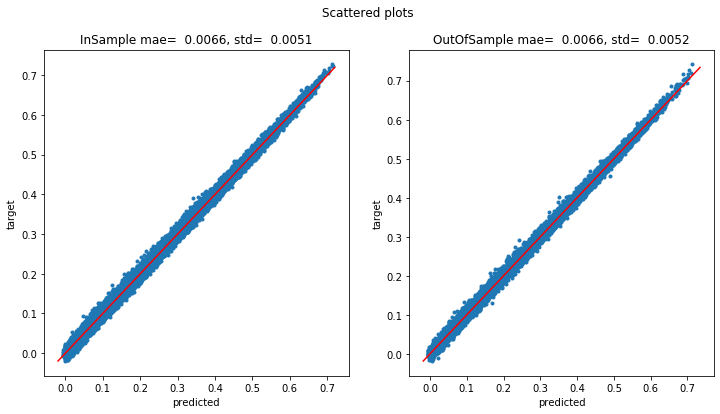

691/691 [==============================] - 1s 1ms/step - loss: 7.1202e-05 - mae: 0.0066
Score:
[7.120226655388251e-05, 0.006647638510912657]


In [95]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy             as np

display_nn_results(model, X_train, X_test, t_train, t_test, resFile = resFile)

## Save Scaler and Model on Disk

In [96]:
from pickle import dump, load

dump(scaler, open(scalerFile, 'wb'))
print("@ %-24s: scaler saved to '%s'" %("Info", scalerFile))

model.save(mdlDir)
print("@ %-24s: model saved to '%s'" %("Info", mdlDir))    

@ Info                    : scaler saved to 'scaler_100000_VFA.pkl'
INFO:tensorflow:Assets written to: model_100000_VFA.krs\assets
@ Info                    : model saved to 'model_100000_VFA.krs'


In [97]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(scalerFile)
    #files.download(mdlDir)

## Using the History Object

The ***fit()*** method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly
a dictionary (history.history) containing the loss and extra metrics it
measured at the end of each epoch on the training set and on the validation set (if any). If you create a Pandas DataFrame using this dictionary and call its plot()
method, you get the learning curves.

In [98]:
X = db.drop(columns="Price")
Y = db["Price"]

In [99]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=50, verbose=1)

Epoch 1/50
1403/1403 [==============================] - 4s 2ms/step - loss: 0.0024 - mae: 0.0286 - val_loss: 4.9044e-04 - val_mae: 0.0193
Epoch 2/50
1403/1403 [==============================] - 3s 2ms/step - loss: 2.8533e-04 - mae: 0.0133 - val_loss: 1.2333e-04 - val_mae: 0.0087
Epoch 3/50
1403/1403 [==============================] - 3s 2ms/step - loss: 2.3538e-04 - mae: 0.0122 - val_loss: 3.7412e-04 - val_mae: 0.0167
Epoch 4/50
1403/1403 [==============================] - 3s 2ms/step - loss: 2.1653e-04 - mae: 0.0117 - val_loss: 5.1010e-04 - val_mae: 0.0192
Epoch 5/50
1403/1403 [==============================] - 3s 2ms/step - loss: 2.0870e-04 - mae: 0.0115 - val_loss: 8.6121e-05 - val_mae: 0.0073
Epoch 6/50
1403/1403 [==============================] - 3s 2ms/step - loss: 1.9933e-04 - mae: 0.0112 - val_loss: 5.7352e-04 - val_mae: 0.0212
Epoch 7/50
1403/1403 [==============================] - 3s 2ms/step - loss: 1.9522e-04 - mae: 0.0110 - val_loss: 1.5813e-04 - val_mae: 0.0101
Epoch 8/50

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


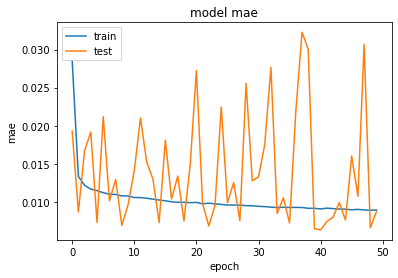

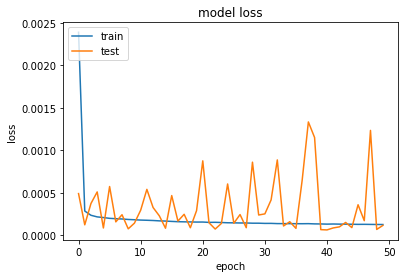

In [100]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()